In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
from decimal import Decimal

from tqdm import tqdm
from tqdm import trange

import random
from itertools import product
import itertools

from scipy.stats import mannwhitneyu as MWU
import scipy

n, n_iter, alpha, lfc_min_thershold, base_mean_min_threshold, min_percentage, max_cutoff, normalization_type = 1000, 2, 0.1, 0.1, 0.1, 0.0, 0.2, 'RUV'

In [16]:
subset_size = 0.01
subset = False

In [18]:
def flatten_list(list1):
    return [item for sublist in list1 for item in sublist]

In [19]:

p = open("../data/actual_proportions.n."+ str(n) + '.n_iter.' + str(n_iter) + '.txt').read().splitlines()

p = sorted(set([float(i) for i in p]))


In [10]:
summary_df = pd.read_csv('../data/' + normalization_type + 'summary_df_n_' + str(n) + '_n_iter_' + str(n_iter) + '.csv',index_col = 0)

print('Add psuedocount to jaccard and take log')
# psuedocount = 10**-3

metrics = summary_df.columns[2:]
n_combs = summary_df.shape[0]
for metric in metrics:
    na_amount = summary_df[summary_df[metric].isna()].shape[0]
    print('{}'.format(na_amount) + ' of {} subset combinations are na for '.format(n_combs) + metric)

summary_df.rename(columns = {'Avg Rin': 'Avg RIN'}, inplace = True)
summary_df.to_csv('../data/' + normalization_type + 'visualize_summary_df__n_' + str(n) + '_n_iter_' + str(n_iter) + '.csv')


Add psuedocount to jaccard and take log
0 of 11994000 subset combinations are na for Correlation
0 of 11994000 subset combinations are na for Jaccard
0 of 11994000 subset combinations are na for Avg Freeze Thaw
0 of 11994000 subset combinations are na for Avg Rin
0 of 11994000 subset combinations are na for Correlation Significante


In [21]:
# for glms
sdf = summary_df.copy()
sdf['Proportion'] = sdf['Proportion'].map(dict(zip(sorted(set(summary_df['Proportion'])), [4,6,8,10,12,14])))
sdf.to_csv('../data/' + normalization_type + 'visualize_summary_df__n_' + str(n) + '_n_iter_' + str(n_iter) + '.csv')

In [22]:
if subset:
    index = sorted(random.sample(summary_df.index.tolist(), int(summary_df.shape[0]*subset_size)))
    summary_df = summary_df.loc[index,:]

# Double check this correlation significance

In [23]:
metrics = ['Correlation', 'Avg Freeze Thaw', 'Avg RIN']
splits = [2,2,2]
metric_split_map = dict(zip(metrics,splits))

for k in trange(len(metrics)):
    metric = metrics[k]
    split = splits[k]
    
    def bin_by_proportion(x):
        try:
            return pd.qcut(x,split)
        except:
            print('Did not work for ' + metric + ' by proportion')
            return pd.cut(x, split)
        
        
    summary_df[metric + ' Bins by Proportion'] = summary_df.groupby('Proportion')[metric].apply(bin_by_proportion)

    summary_df.sort_values(by = 'Proportion', inplace = True)
    summary_df.reset_index(inplace = True, drop = True)
    test_index = []
    bin_rank_list = []
    for p_ in sorted(set(summary_df['Proportion'])):
        d = summary_df[summary_df['Proportion'] == p_]
        test_index.append(d.index.tolist())
        bin_rank = dict(zip(sorted(d[metric + ' Bins by Proportion'].unique()), [0,1]))
        bin_rank_list += d[metric + ' Bins by Proportion'].map(bin_rank).tolist()
    
    if flatten_list(test_index) == summary_df.index.tolist():
        summary_df[metric + ' Ranks by Proportion'] = bin_rank_list
    else:
        raise ValueError('Did not work')

 25%|██▌       | 1/4 [01:06<03:18, 66.28s/it]

Did not work for Jaccard by proportion
Did not work for Jaccard by proportion
Did not work for Jaccard by proportion
Did not work for Jaccard by proportion
Did not work for Jaccard by proportion
Did not work for Jaccard by proportion


100%|██████████| 4/4 [03:40<00:00, 55.14s/it]


In [24]:
metrics = ['Avg Freeze Thaw', 'Avg RIN']

freeze_thaw_map = {0: 'High Sample Quality', 1: 'Low Sample Quality'}
RIN_map = {1: 'High Sample Quality', 0: 'Low Sample Quality'}
maps = [freeze_thaw_map, RIN_map]

for i in range(len(metrics)):
    metric = metrics[i]
    summary_df[metric + ' Ranks by Proportion'] = summary_df[metric + ' Ranks by Proportion'].map(maps[i])

In [11]:
a = sorted(set(summary_df['Proportion']))
b = [4,6,8,10,12,14]
proportion_to_size = dict(zip(a,b))

In [1]:
print('Visualize no swarmplot LFC v proportion')
sns.set(style = 'white', font_scale = 2)
# similarity_metrics = [correlation_df, jaccard_df.iloc[:,2:]]
metrics = ['Correlation']
fig,ax = plt.subplots(figsize = (10,10), ncols=1, nrows=1)
title = ['']

colors = sns.color_palette("Blues")
for i in range(len(metrics)):
    metric = metrics[i]
    
    
    if (metric == 'Correlation')  and (filter_sig_cor == True):
        sns.violinplot(x = 'Proportion', y = metric, data = summary_df[summary_df['Correlation Significante'] == 1], 
                       palette = colors, inner = 'quartile', ax = ax[i])
    else:
        sns.boxplot(x = 'Proportion', y = metric, data = summary_df, 
                       palette = colors, ax = ax[i])
   
    ax[i].set_title(title[i])
    ax[i].set_xticklabels(['{}'.format(proportion_to_size[p_]) for p_ in sorted(set(summary_df['Proportion']))]);
    ax[i].set_xlabel('Subset Size')
    ax[i].set_ylabel('Similarity')



fig.subplots_adjust(top = 0.92, bottom=0.01, hspace=0.3, wspace=0.15)


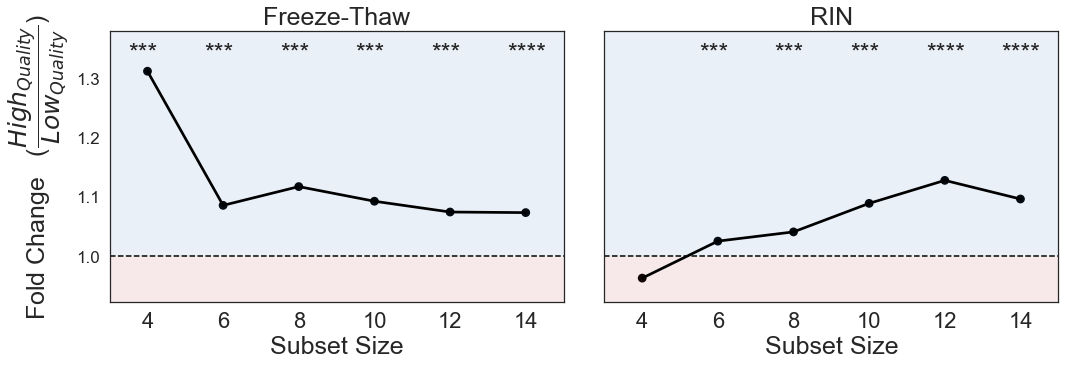

In [62]:
blue = sns.color_palette("RdBu_r", 7)[0]
red = sns.color_palette("RdBu_r", 7)[-1]

metrics = ['Correlation']
ranks = ['Avg Freeze Thaw', 'Avg RIN']
fig, ax = plt.subplots(ncols = len(ranks),nrows = len(metrics), figsize = (17,5))
sns.set(style = 'white', font_scale = 1)
p_list = []

metric = metrics[0]
for j in range(len(ranks)):
    rank = ranks[j]


    median_vals = summary_df.groupby(['Proportion', rank + ' Ranks by Proportion'])['Correlation'].median()
    median_vals = median_vals.unstack() 
    # fold change of high with respect to low
    median_vals = pd.DataFrame(np.divide(median_vals.loc[:, 'High Sample Quality'], 
                                         median_vals.loc[:, 'Low Sample Quality']), 
                              columns = ['Fold Change'])

    median_vals['Proportion'] = median_vals.index
    

    sns.pointplot(x = 'Proportion', y = 'Fold Change', data = median_vals, ax = ax[j], color = 'black')
    
    if j == 0:
        ax[j].set_ylabel('Fold Change   ($\\dfrac {High_{Quality}}{Low_{Quality}}$)', fontsize = 25)
        ax[j].set_title('Freeze-Thaw', fontsize = 25)
    else:
        ax[j].set_ylabel('')
        ax[j].set_title('RIN', fontsize = 25)
    ax[j].set_xlabel('Subset Size', fontsize = 25)
    ax[j].set_xticklabels(['{}'.format(proportion_to_size[p_]) for p_ in sorted(set(summary_df['Proportion']))])
    ax[j].tick_params(axis='x', which='major', labelsize=22)
    ax[j].tick_params(axis='y', which='major', labelsize=17)
    # MWU test: null is that high sample quality similarity is not higher than low sample quality
    pvals_df = pd.DataFrame(columns = ['PVAL'])
    for p_ in sorted(set(summary_df['Proportion'])):
        bin_0 = summary_df[metric][(summary_df['Proportion'] == p_) 
                                   & (summary_df[rank + ' Ranks by Proportion'] == 'Low Sample Quality')]
        bin_1 = summary_df[metric][(summary_df['Proportion'] == p_) 
                                   & (summary_df[rank + ' Ranks by Proportion'] == 'High Sample Quality')]

        pvals_df.loc[p_, 'PVAL'] =  MWU(bin_1, bin_0, use_continuity = False, alternative = 'greater')[1]
    
    # draw pvals
    if ax[j].get_ylim()[1] > 0:
        ylim_annot = ax[j].get_ylim()[1]*1.02
        new_ylim_top = ax[j].get_ylim()[1]*1.04
        new_ylim_bottom = ax[j].get_ylim()[0]
    else:
        ylim_annot = ax[j].get_ylim()[1]*0.995
        new_ylim_top = ax[j].get_ylim()[1]*0.98
        new_ylim_bottom = ax[j].get_ylim()[0]*1.05
    ax[j].set_ylim(new_ylim_bottom,new_ylim_top)
    ax[j].axhline(y=1, linestyle='--', c = 'black')

    p_list += [pvals_df]

first = ax[0].get_ylim()
second = ax[1].get_ylim()
ax[0].set_ylim(second[0] - 0.03, first[1])
ax[1].set_ylim(second[0] - 0.03, first[1])
ax[1].yaxis.set_ticklabels([])
for j in range(2):
    ax[j].axhspan(second[0] - 0.03, 1, facecolor=red, alpha=0.1)
    ax[j].axhspan(1, first[1], facecolor=blue, alpha=0.1)

# add pvals to graph
j = -1
for pvals_df in p_list:
    j += 1
    counter = 0
    for k in pvals_df.index:
        pval = pvals_df.loc[k,'PVAL']
        if pval == 0:
            ax[j].annotate('****', xycoords='data', fontsize = 25,
                             xy=(list(ax[j].get_xticks())[counter]-0.25, 1.33))
        elif pval < 0.001:
            ax[j].annotate('***', xycoords='data', fontsize = 25,
                             xy=(list(ax[j].get_xticks())[counter]-0.25, 1.33))
        elif pval < 0.01:
            ax[j].annotate('**', xycoords='data', fontsize = 25,
                             xy=(list(ax[j].get_xticks())[counter]-0.25, 1.33))
        elif pval < 0.05:
            ax[j].annotate('*', xycoords='data',fontsize = 25,
                             xy=(list(ax[j].get_xticks())[counter]-0.25, 1.33))


        counter += 1
        

fig.subplots_adjust(wspace=0.09)

  

In [ ]:
library(lme4)

n = 1000
n_iter = 2

RUV=read.csv(paste0('../data/RUVsdf_n_',n,'_n_iter_', n_iter,'.csv'))

d_RUV = matrix(1:3, nrow = 3, dimnames = list(c('(GLM ~ Sample Size + Freeze Thaw + RIN)', '(GLM ~ Freeze Thaw)', '(GLM ~ RIN)'), c('AIC')) )


t = glm( Correlation ~ Proportion + Avg.Freeze.Thaw + Avg.Rin, data=RUV)
write.csv( coef( summary( t ) ), file =  "../data/RUV_Correlation_GLM_ALL.csv")
d_RUV[1,1] = AIC(t)

t = glm( Correlation ~ Avg.Freeze.Thaw, data=RUV)
write.csv( coef( summary( t ) ), file =  "../data/RUV_Correlation_GLM_FT.csv")
d_RUV[2,1] = AIC(t)

t = glm( Correlation ~ Avg.Rin, data=RUV)
write.csv( coef( summary( t ) ), file =  "../data/RUV_Correlation_GLM_RIN.csv")
d_RUV[3,1] = AIC(t)

write.csv(d_RUV, file = "../data/RUV_GLM_AIC.csv")